# Objective 

Author: Kate Lassiter

This notebook shows the approach taken in the final wrist activity classification model, with use of over sampling of minority class with random noise and custom precision loss. It is then further refined to loop through subjects with some fine-tuning approaches. 

In [3]:
import sys
sys.path.append("../")
import joblib
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from utils.data import NormalDataset, resize, get_inverse_class_weights
from utils.utils import EarlyStopping
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [4]:
# Data Tranformations
csv_file_path = "/XXXX.csv"
hip_data = pd.read_csv(csv_file_path)

num_rows = hip_data.shape[0] # Add a 'group' field, dividing the dataset into 10 equal parts
group_size = num_rows // 10  # Calculate the number of rows per group
# Create an array with group labels (1 to 10) repeated for each group size
group_labels = np.repeat(np.arange(1, 11), group_size)

# If remaining rows due to integer division assign them to last group
if len(group_labels) < num_rows:
    group_labels = np.concatenate([group_labels, np.full(num_rows - len(group_labels), 10)])
hip_data['group'] = group_labels # Assign the group labels 

X = hip_data[['x', 'y', 'z']].values
y = hip_data['annotation'].values
groups = hip_data['group'].values

# Reshape the data into windows of size X
def create_windows(data, labels, groups, window_size):
    num_windows = data.shape[0] // window_size
    X_windows = data[:num_windows * window_size].reshape(num_windows, window_size, -1)
    y_windows = labels[window_size-1:num_windows * window_size:window_size]  # One label per window
    group_windows = groups[window_size-1:num_windows * window_size:window_size]  # One group per window
    return X_windows, y_windows, group_windows

# Random Oversampling Minority Class

In [5]:
window_size = 1000
X_windows, y_windows, group_windows= create_windows(X, y, groups, window_size)
x_train, x_temp, y_train, y_temp, group_train, group_temp = train_test_split(
    X_windows, y_windows, group_windows, test_size=0.3, random_state=42
)

x_train_ros, y_train_ros = RandomOverSampler(random_state=42).fit_resample(x_train.reshape(x_train.shape[0], -1), y_train)
noise_factor = 0.1 # Slight random noise, avoid duplications for minority
x_train_ros= x_train_ros+(np.random.normal(size=x_train_ros.shape)*noise_factor)
group_train_ros = np.tile(group_train,int(np.ceil(len(x_train_ros.reshape(-1, window_size, 3))/len(group_train))))[:len(x_train_ros.reshape(-1, window_size, 3))]

x_val, x_test,y_val, y_test, group_val, group_test = train_test_split(
    x_train_ros.reshape(-1, window_size, 3), y_train_ros, group_train_ros, test_size=0.5, random_state=42
)
print(((x_train_ros.reshape(-1, window_size, 3).shape, y_train_ros.shape, group_train_ros.shape),
       (x_val.shape,y_val.shape, group_val.shape),
       (x_test.shape, y_test.shape, group_test.shape)))

(((500, 1000, 3), (500,), (500,)), ((250, 1000, 3), (250,), (250,)), ((250, 1000, 3), (250,), (250,)))


In [9]:
train_dataset = NormalDataset(x_train_ros.reshape(-1, window_size, 3), y_train_ros, group_train_ros, name="training", transform=True)
test_dataset = NormalDataset(x_test, y_test, group_test, name="test")

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0,
)

training set sample count : 500
test set sample count : 250


### KEY: validation set MUST be class-imbalanced (mostly negative samples)

In [11]:
val_0 = [x for x in range(len(y_val)) if y_val[x] == 0]
val_1 = [x for x in range(len(y_val)) if y_val[x] == 1]
val_favorable = val_0 + list(np.random.choice(val_1, size=len(val_0) // 10, replace=False))
val_favorable_dataset = NormalDataset(x_val[val_favorable], y_val[val_favorable], group_val[val_favorable], name="validation")
val_favorable_loader= DataLoader(val_favorable_dataset, batch_size=128, shuffle=False)

validation set sample count : 129


In [13]:
#Using Harnet30
repo = 'OxWearables/ssl-wearables'
sslnet: nn.Module = torch.hub.load(repo, 'harnet30', trust_repo=True, class_num=2, pretrained=True, weights_only=False)
sslnet.to(device)

Using cache found in /Users/kat/.cache/torch/hub/OxWearables_ssl-wearables_main
/Users/kat/.cache/torch/hub/OxWearables_ssl-wearables_main/hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to th

131 Weights loaded


Resnet(
  (feature_extractor): Sequential(
    (layer1): Sequential(
      (0): Conv1d(3, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
      (1): ResBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (relu): ReLU(inplace=True)
      )
      (2): ResBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (conv2): Conv1d(6

In [17]:
for name, param in sslnet.named_parameters():
    print(name)

feature_extractor.layer1.0.weight
feature_extractor.layer1.1.bn1.weight
feature_extractor.layer1.1.bn1.bias
feature_extractor.layer1.1.bn2.weight
feature_extractor.layer1.1.bn2.bias
feature_extractor.layer1.1.conv1.weight
feature_extractor.layer1.1.conv2.weight
feature_extractor.layer1.2.bn1.weight
feature_extractor.layer1.2.bn1.bias
feature_extractor.layer1.2.bn2.weight
feature_extractor.layer1.2.bn2.bias
feature_extractor.layer1.2.conv1.weight
feature_extractor.layer1.2.conv2.weight
feature_extractor.layer1.3.weight
feature_extractor.layer1.3.bias
feature_extractor.layer2.0.weight
feature_extractor.layer2.1.bn1.weight
feature_extractor.layer2.1.bn1.bias
feature_extractor.layer2.1.bn2.weight
feature_extractor.layer2.1.bn2.bias
feature_extractor.layer2.1.conv1.weight
feature_extractor.layer2.1.conv2.weight
feature_extractor.layer2.2.bn1.weight
feature_extractor.layer2.2.bn1.bias
feature_extractor.layer2.2.bn2.weight
feature_extractor.layer2.2.bn2.bias
feature_extractor.layer2.2.conv1.w

### Trying Fine Tuning: Freezing Convolutional Layers, Not linear layers

In [21]:
def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find("BatchNorm1d") != -1:
        m.eval()
        
i = 0
name_idx = 0
for name, param in sslnet.named_parameters():
    if name.split(".")[name_idx] == "feature_extractor":
        param.requires_grad = False
        i += 1
sslnet.apply(set_bn_eval)

Resnet(
  (feature_extractor): Sequential(
    (layer1): Sequential(
      (0): Conv1d(3, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
      (1): ResBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (relu): ReLU(inplace=True)
      )
      (2): ResBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (conv2): Conv1d(6

In [23]:
print("Weights frozen: %d" % i)

Weights being frozen: 63


## Improving metrics other than accuracy

I implemented both a custom recall and precision loss function for the deep learning model. Our team opted to focus on precision.

### Custom recall focused loss function

In [ ]:
class RecallLoss(nn.Module):
    def __init__(self, weighted_fn=5, weighted_fp=1):
        super(RecallLoss, self).__init__()
        self.weighted_fn = weighted_fn
        self.weighted_fp = weighted_fp

    def forward(self, outputs, labels):
        probs = F.softmax(outputs, dim=1)
        pos_mask = labels.float() 
        fn_loss = -torch.log(probs[:, 1] + 1e-6) * pos_mask * self.weighted_fn
        fp_loss = -torch.log(probs[:, 0] + 1e-6) * (1 - pos_mask) * self.weighted_fp
        return fn_loss.mean() + fp_loss.mean()

# Initialize with higher penalty for false negatives
loss_fn = PrecisionLoss(weighted_fp=1, weighted_fn=10).to(device)

In [ ]:
sslnet = sslnet.to(device).double()

def train_with_recall(model, train_loader, val_loader, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)
    num_epochs = 30  
    best_val_precision = 0  
    epochs_without_improvement = 0  
    patience=3
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        all_train_labels = []
        all_train_preds = []
        #Train
        for batch in train_loader:
            if len(batch) == 3:
                inputs, labels, _ = batch 
            else:
                inputs, labels = batch  

            inputs, labels = inputs.to(device).double(), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_conf_matrix = confusion_matrix(all_train_labels, all_train_preds)
        train_true_positives = train_conf_matrix[1, 1]
        train_false_negatives = train_conf_matrix[0, 1]
        train_recall = train_true_positives / (train_true_positives + train_false_negatives)

        #Validate
        model.eval()
        all_val_labels = []
        all_val_preds = []
        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    inputs, labels, _ = batch
                else:
                    inputs, labels = batch

                inputs, labels = inputs.to(device).double(), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())
                
        val_conf_matrix = confusion_matrix(all_val_labels, all_val_preds)
        val_true_positives = val_conf_matrix[1, 1]
        val_false_negatives = val_conf_matrix[0, 1]
        val_recall = val_true_positives / (val_true_positives + val_false_negatives)

        if val_recall > best_val_precision:
            best_val_precision = val_recall
            epochs_without_improvement = 0  # Reset counter if improvement
        else:
            epochs_without_improvement += 1  # Increment counter if no improvement

       # if epochs_without_improvement >= patience:
            # print(f"Early stopping on epoch {epoch + 1} as validation precision did not improve for {patience} epochs.")
            # break

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"  Train Loss: {sum(train_losses) / len(train_losses):.4f}")
        print(f"  Train Recall: {train_recall:.4f}")
        print(f"  Validation Recall: {val_recall:.4f}")
        plt.figure(figsize=(8, 6))
        sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Training Confusion Matrix')
        plt.show()
        plt.figure(figsize=(8, 6))
        sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Validation Confusion Matrix')
        plt.show()

def predict(model, data_loader, device):
    predictions_list = []
    true_list = []
    pid_list = []
    model.eval()
    for i, (x, y, pid) in enumerate(tqdm(data_loader)):
        with torch.inference_mode():
            x = x.to(device, dtype=torch.float)
            logits = model(x)
            true_list.append(y)
            pred_y = torch.argmax(logits, dim=1)
            predictions_list.append(pred_y.cpu())
            pid_list.extend(pid)
    true_list = torch.cat(true_list)
    predictions_list = torch.cat(predictions_list)

    return (
        torch.flatten(true_list).numpy(),
        torch.flatten(predictions_list).numpy(),
        np.array(pid_list),
    )

### Custom precision focused loss function

In [25]:
class PrecisionLoss(nn.Module):
    def __init__(self, weighted_fp=2, weighted_fn=1):
        super().__init__()
        self.weighted_fp =weighted_fp
        self.weighted_fn= weighted_fn

    def forward(self, outputs, labels):
        probs= F.softmax(outputs, dim=1)
        pos_mask= labels.float()
        fp_loss= -torch.log(probs[:,0] + 1e-6)*(1 - pos_mask) *self.weighted_fp
        fn_loss= -torch.log(probs[:, 1] + 1e-6) *pos_mask *self.weighted_fn
        return fp_loss.mean()+fn_loss.mean()

# Initialize with higher penalty for false positives
loss_fn = PrecisionLoss(weighted_fp=10, weighted_fn=1).to(device)

In [ ]:
sslnet = sslnet.to(device).double()

def train_with_precision(model, train_loader, val_loader, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)
    num_epochs = 30  
    best_val_precision = 0  
    epochs_without_improvement = 0  
    patience=3
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        all_train_labels = []
        all_train_preds = []
        #Train
        for batch in train_loader:
            if len(batch) == 3:
                inputs, labels, _ = batch 
            else:
                inputs, labels = batch  

            inputs, labels = inputs.to(device).double(), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_conf_matrix = confusion_matrix(all_train_labels, all_train_preds)
        train_true_positives = train_conf_matrix[1, 1]
        train_false_negatives = train_conf_matrix[0, 1]
        train_recall = train_true_positives / (train_true_positives + train_false_negatives)

        #Validate
        model.eval()
        all_val_labels = []
        all_val_preds = []
        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    inputs, labels, _ = batch
                else:
                    inputs, labels = batch

                inputs, labels = inputs.to(device).double(), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())
                
        val_conf_matrix = confusion_matrix(all_val_labels, all_val_preds)
        val_true_positives = val_conf_matrix[1, 1]
        val_false_negatives = val_conf_matrix[0, 1]
        val_recall = val_true_positives / (val_true_positives + val_false_negatives)

        if val_recall > best_val_precision:
            best_val_precision = val_recall
            epochs_without_improvement = 0  # Reset counter if improvement
        else:
            epochs_without_improvement += 1  # Increment counter if no improvement

       # if epochs_without_improvement >= patience:
            # print(f"Early stopping on epoch {epoch + 1} as validation precision did not improve for {patience} epochs.")
            # break

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"  Train Loss: {sum(train_losses) / len(train_losses):.4f}")
        print(f"  Train Recall: {train_recall:.4f}")
        print(f"  Validation Recall: {val_recall:.4f}")
        plt.figure(figsize=(8, 6))
        sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Training Confusion Matrix')
        plt.show()
        plt.figure(figsize=(8, 6))
        sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Validation Confusion Matrix')
        plt.show()

def predict(model, data_loader, device):
    predictions_list = []
    true_list = []
    pid_list = []
    model.eval()
    for i, (x, y, pid) in enumerate(tqdm(data_loader)):
        with torch.inference_mode():
            x = x.to(device, dtype=torch.float)
            logits = model(x)
            true_list.append(y)
            pred_y = torch.argmax(logits, dim=1)
            predictions_list.append(pred_y.cpu())
            pid_list.extend(pid)
    true_list = torch.cat(true_list)
    predictions_list = torch.cat(predictions_list)

    return (
        torch.flatten(true_list).numpy(),
        torch.flatten(predictions_list).numpy(),
        np.array(pid_list),
    )

Epoch [1/30]
  Train Loss: 8.2244
  Train Recall: 0.6667
  Validation Recall: nan


/var/folders/m6/bmzv652526d9yl3g_l5shcg40000gn/T/ipykernel_74611/2247934318.py:73: RuntimeWarning: invalid value encountered in scalar divide
  val_recall = val_true_positives / (val_true_positives + val_false_negatives)


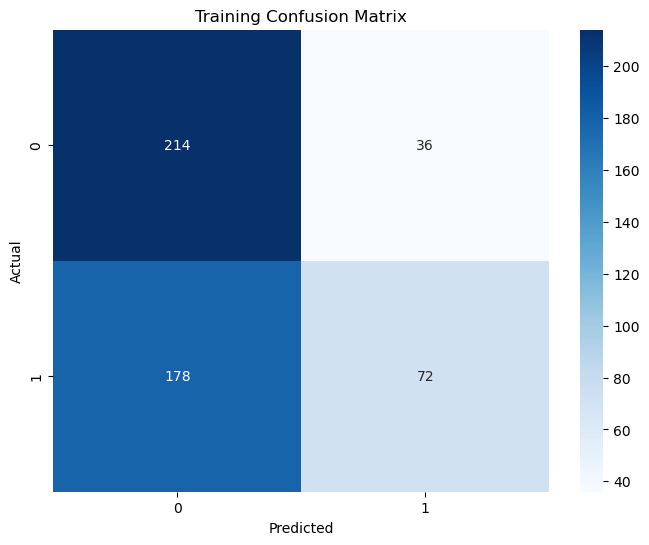

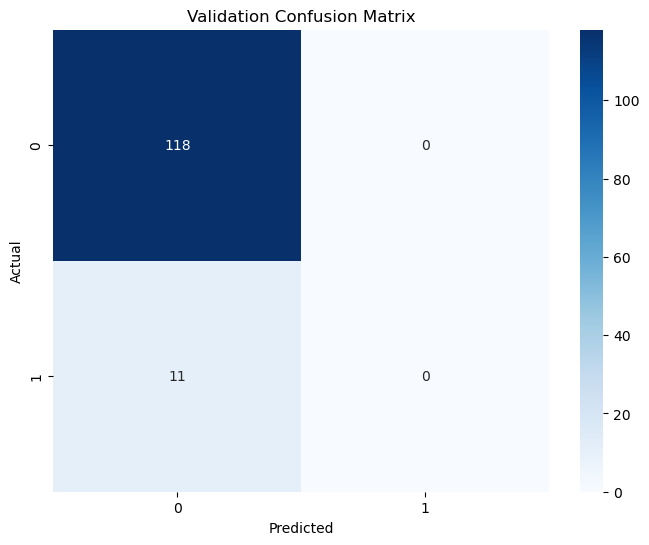

/var/folders/m6/bmzv652526d9yl3g_l5shcg40000gn/T/ipykernel_74611/2247934318.py:73: RuntimeWarning: invalid value encountered in scalar divide
  val_recall = val_true_positives / (val_true_positives + val_false_negatives)


Epoch [2/30]
  Train Loss: 4.5438
  Train Recall: 0.9836
  Validation Recall: nan


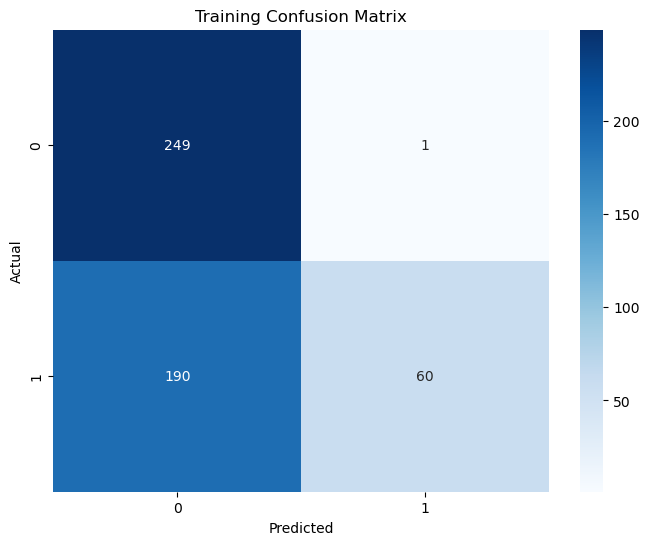

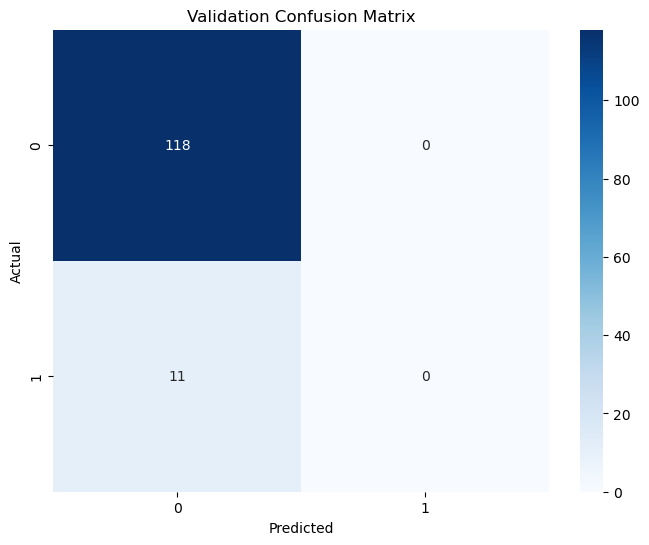

Epoch [3/30]
  Train Loss: 3.6019
  Train Recall: 1.0000
  Validation Recall: nan


/var/folders/m6/bmzv652526d9yl3g_l5shcg40000gn/T/ipykernel_74611/2247934318.py:73: RuntimeWarning: invalid value encountered in scalar divide
  val_recall = val_true_positives / (val_true_positives + val_false_negatives)


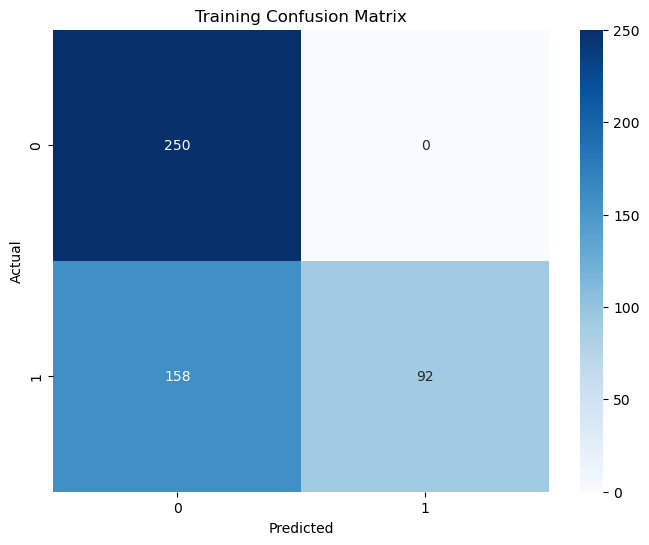

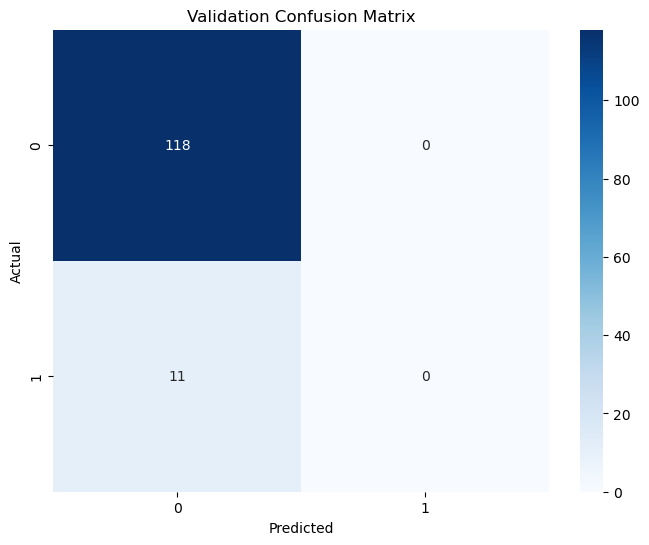

Epoch [4/30]
  Train Loss: 2.4987
  Train Recall: 0.9860
  Validation Recall: 0.6667


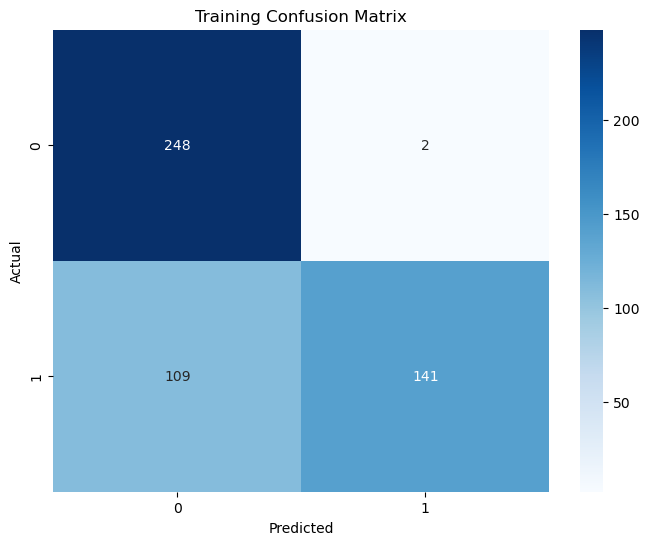

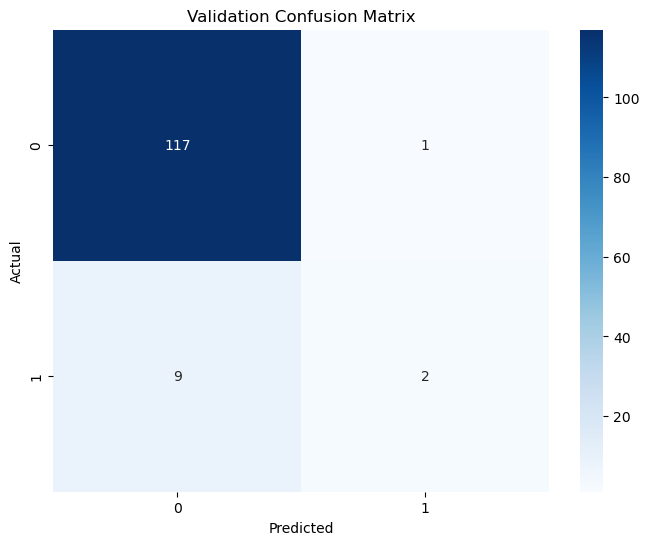

Epoch [5/30]
  Train Loss: 2.7026
  Train Recall: 0.9662
  Validation Recall: 0.8571


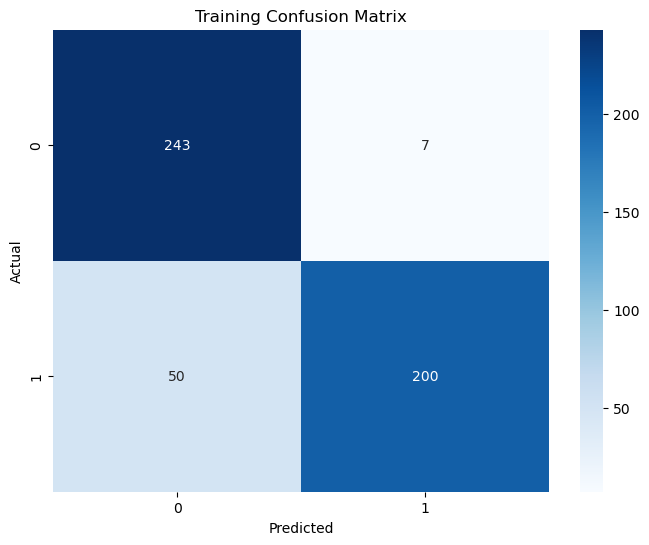

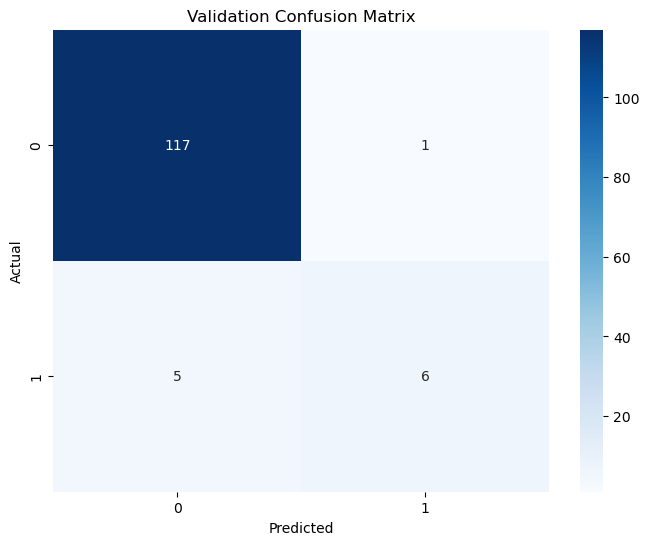

Epoch [6/30]
  Train Loss: 3.6756
  Train Recall: 0.9440
  Validation Recall: 0.8333


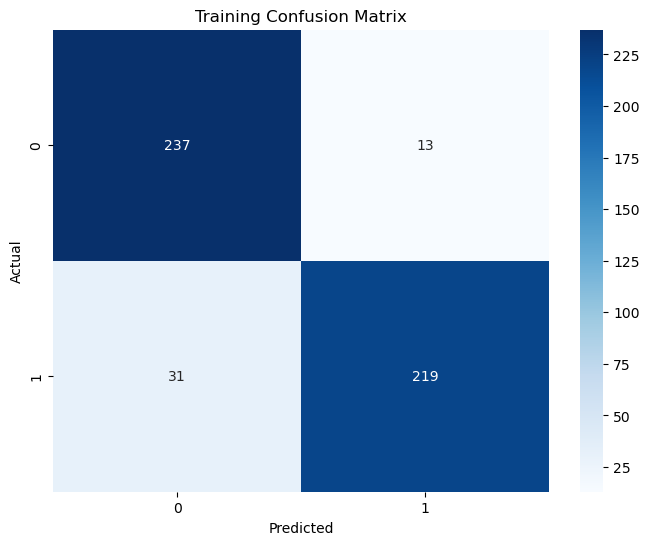

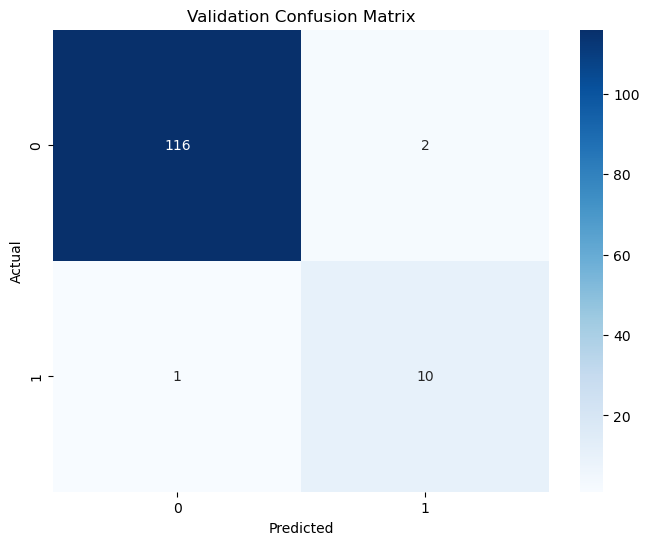

Epoch [7/30]
  Train Loss: 2.7176
  Train Recall: 0.9553
  Validation Recall: 0.7692


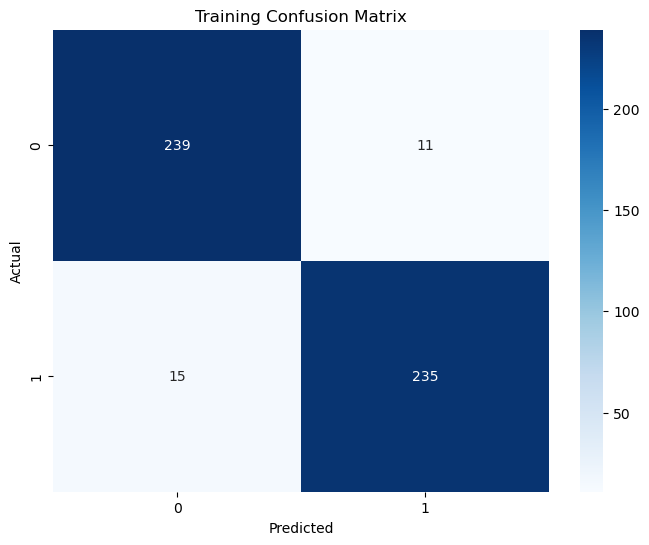

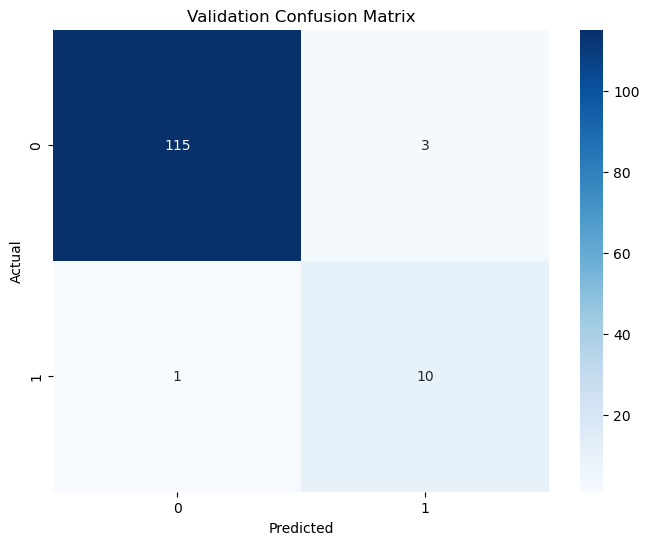

Epoch [8/30]
  Train Loss: 2.0659
  Train Recall: 0.9698
  Validation Recall: 0.8333


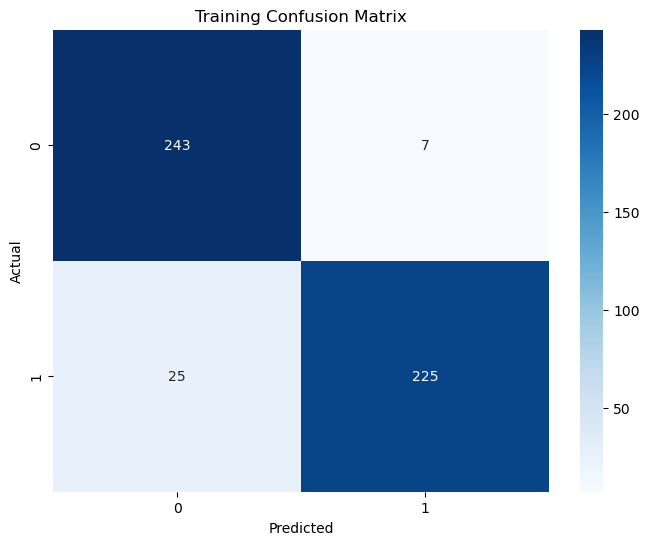

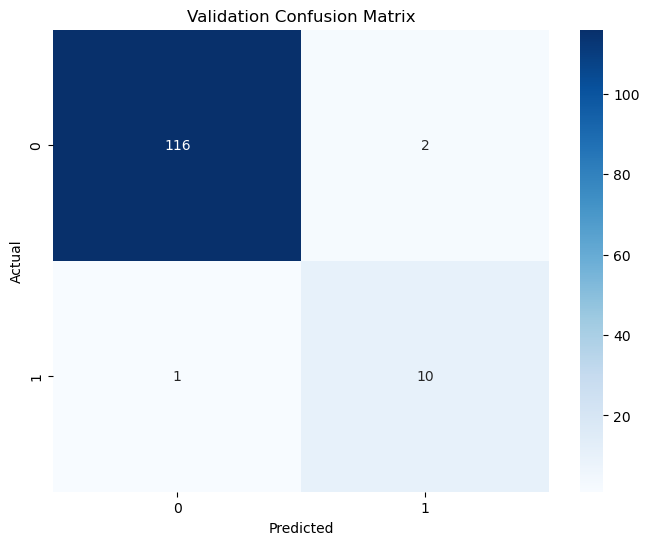

Epoch [9/30]
  Train Loss: 1.5419
  Train Recall: 0.9771
  Validation Recall: 0.8333


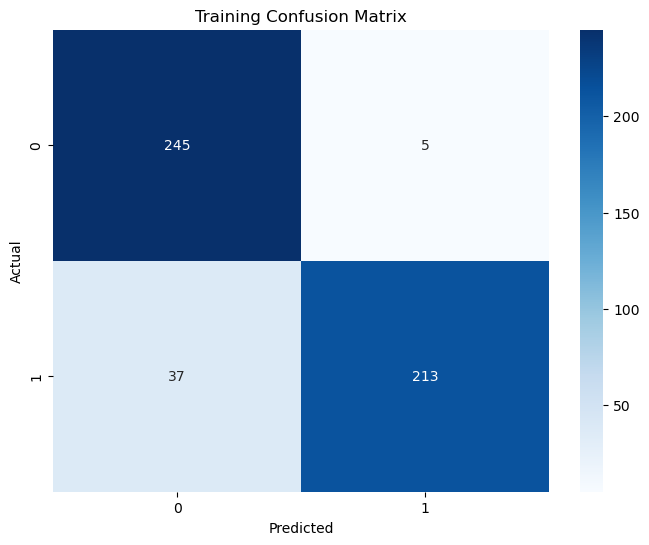

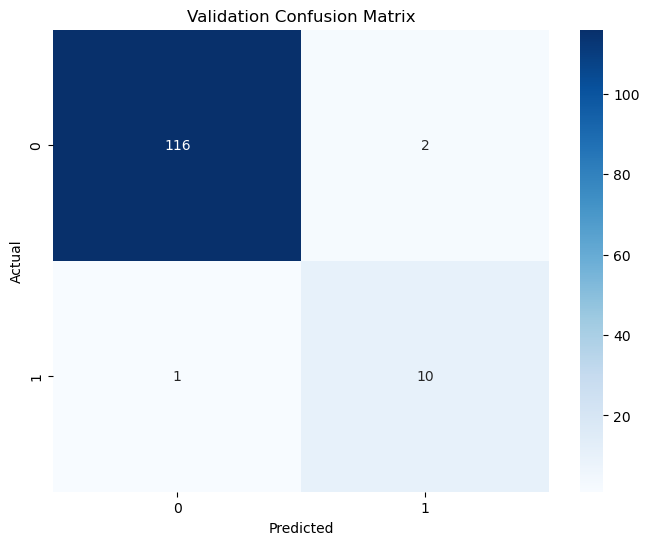

Epoch [10/30]
  Train Loss: 1.2724
  Train Recall: 0.9949
  Validation Recall: 0.8462


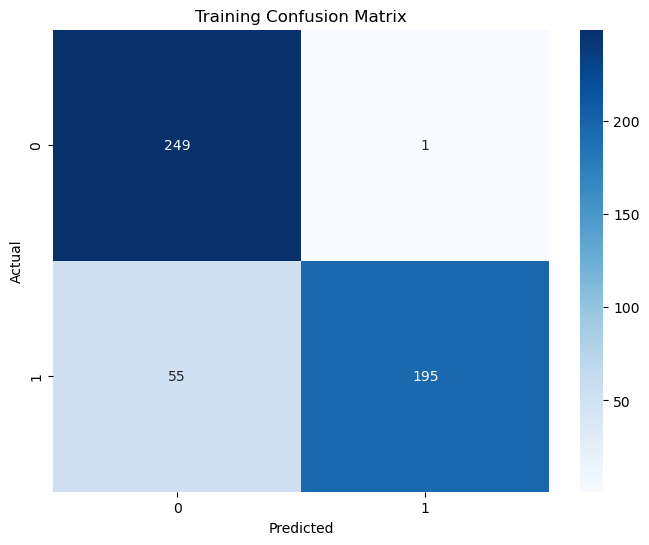

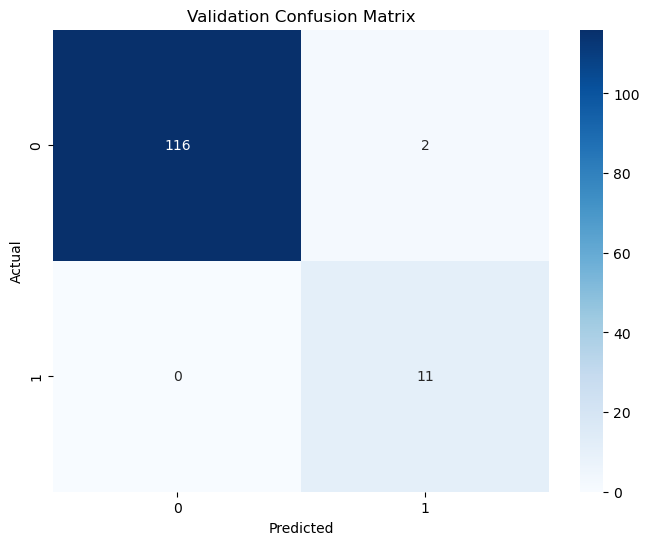

Epoch [11/30]
  Train Loss: 0.9872
  Train Recall: 0.9904
  Validation Recall: 0.8462


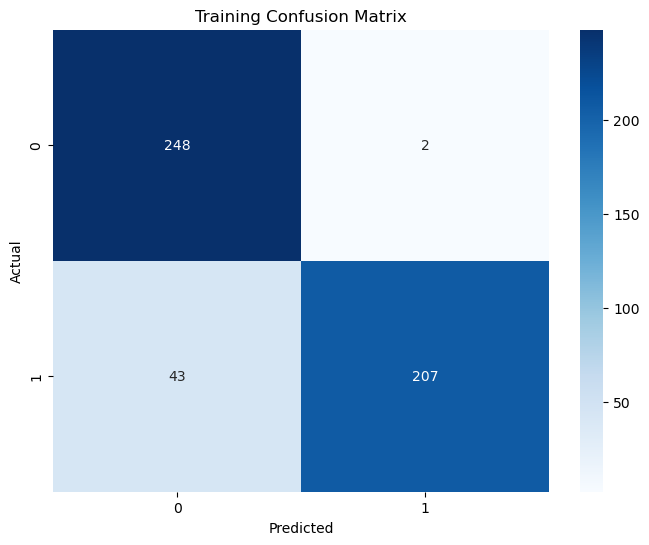

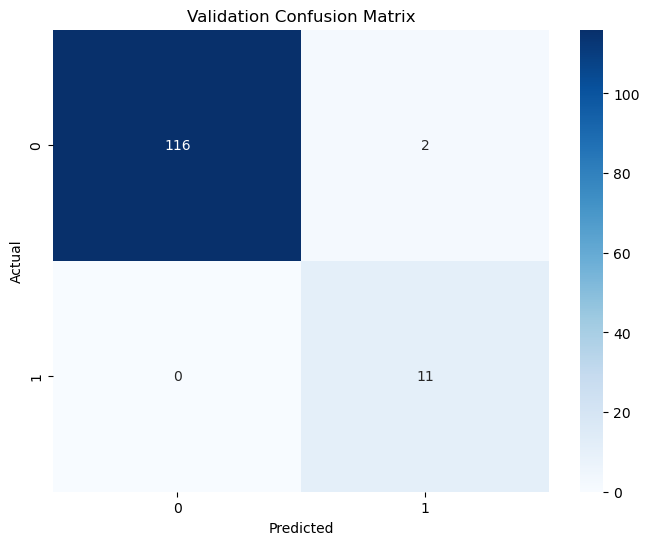

Epoch [12/30]
  Train Loss: 1.0077
  Train Recall: 0.9950
  Validation Recall: 0.8462


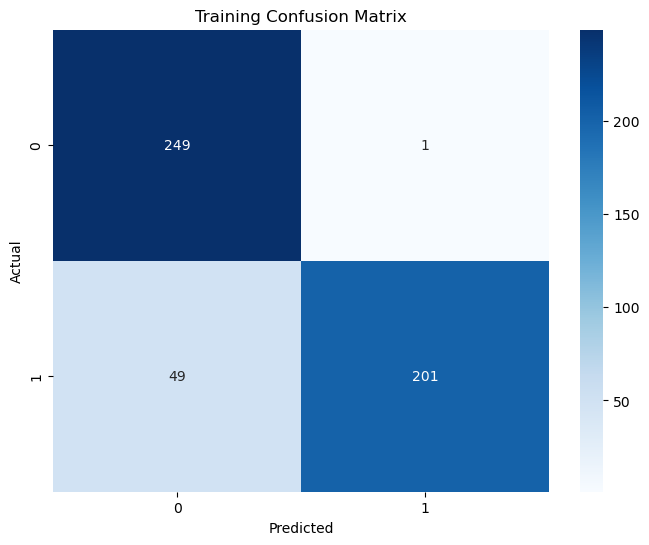

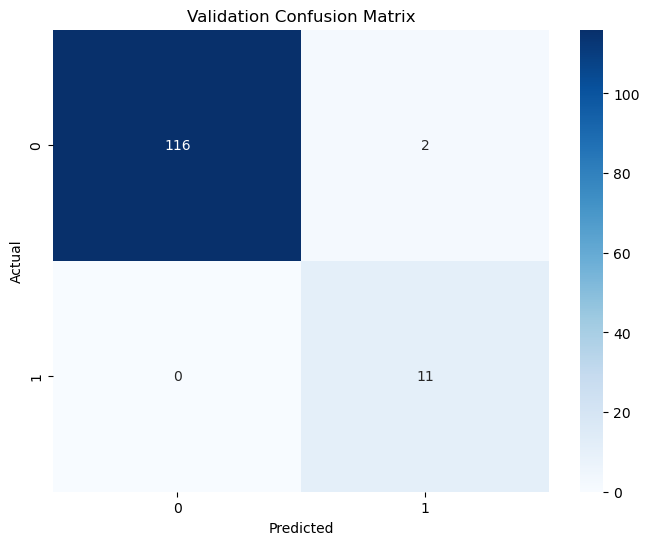

Epoch [13/30]
  Train Loss: 0.6735
  Train Recall: 0.9954
  Validation Recall: 0.8462


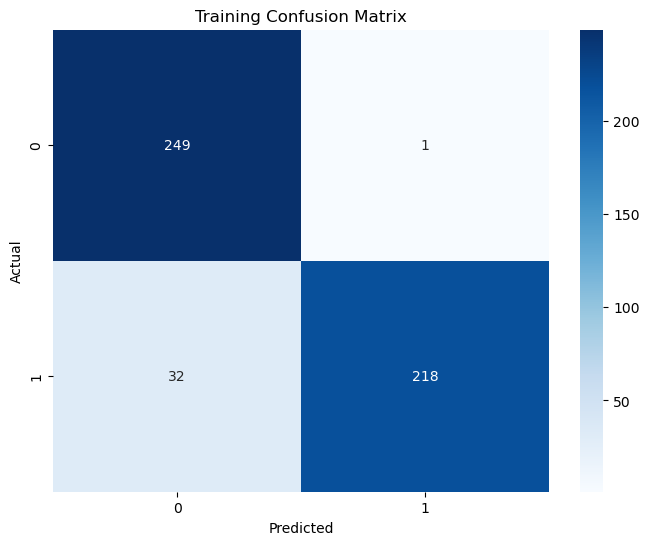

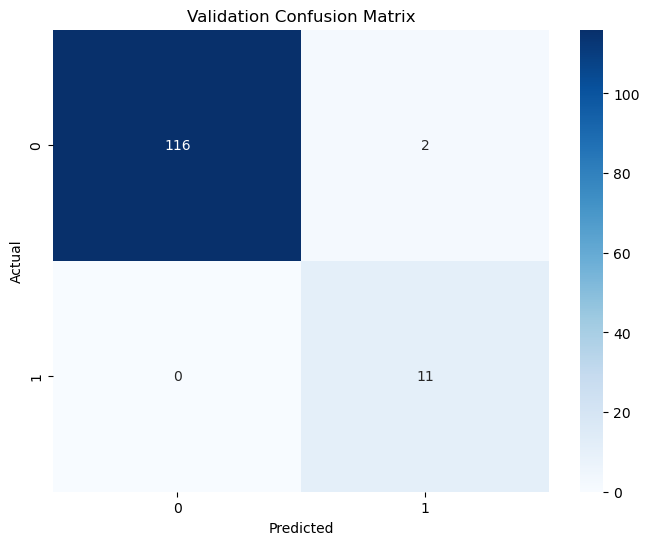

Epoch [14/30]
  Train Loss: 1.0272
  Train Recall: 0.9868
  Validation Recall: 0.7857


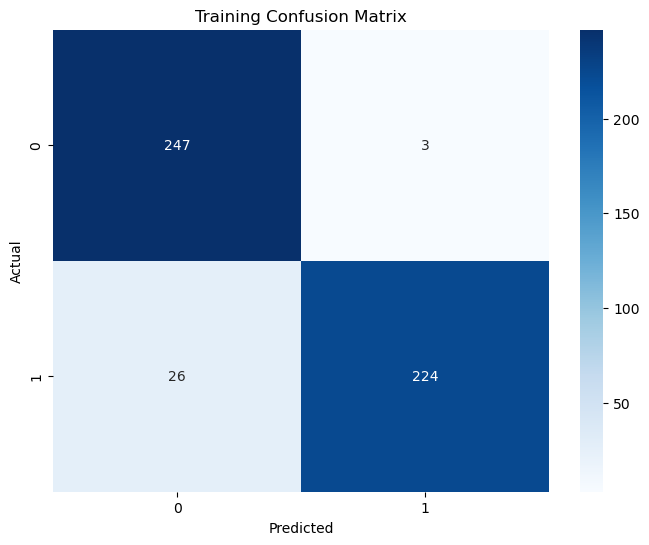

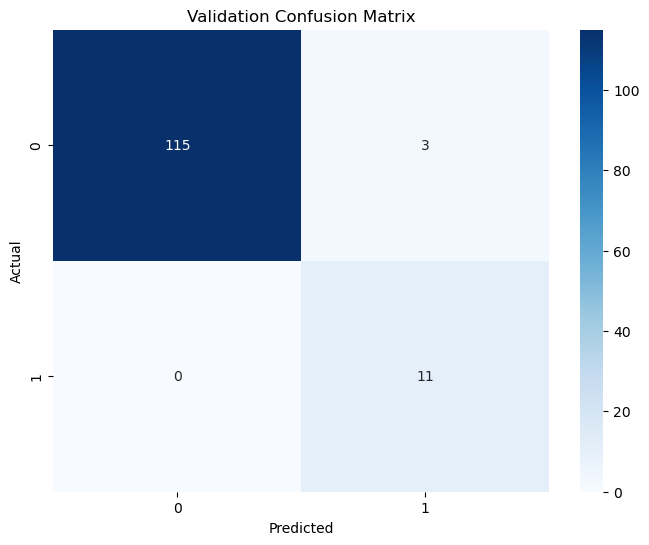

Epoch [15/30]
  Train Loss: 0.8373
  Train Recall: 0.9879
  Validation Recall: 0.7857


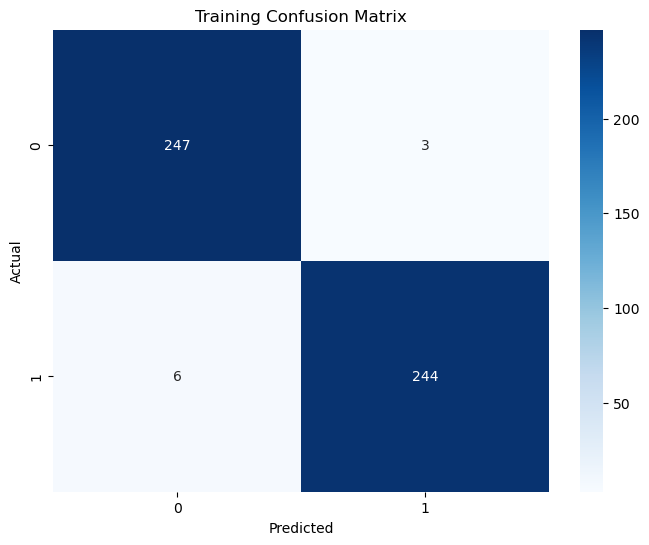

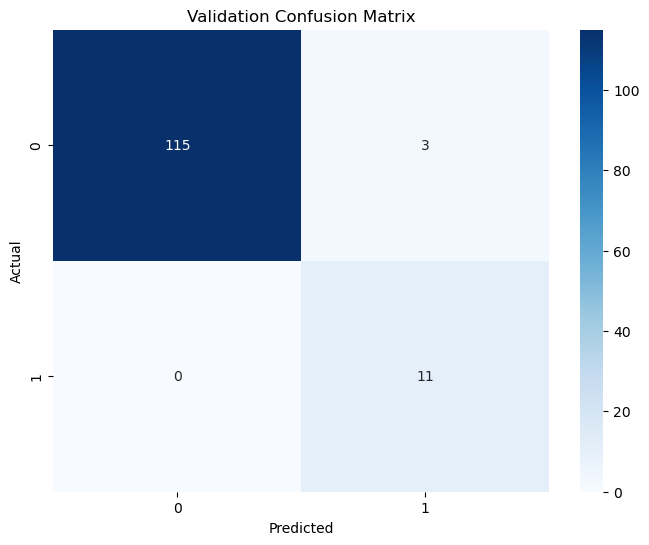

Epoch [16/30]
  Train Loss: 0.6644
  Train Recall: 0.9877
  Validation Recall: 0.7857


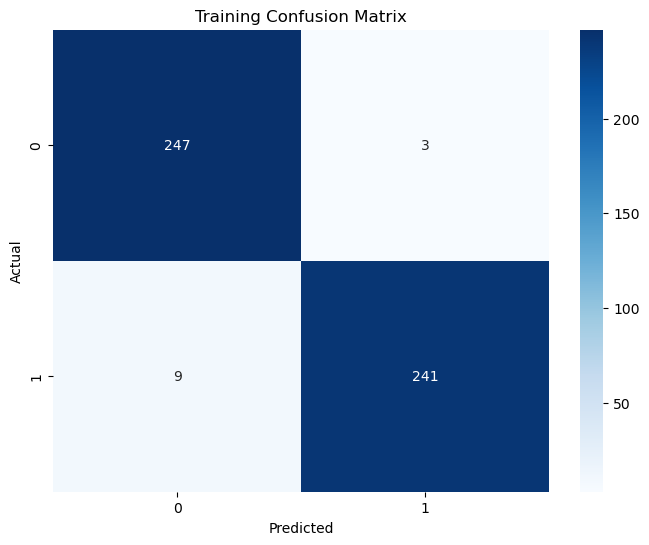

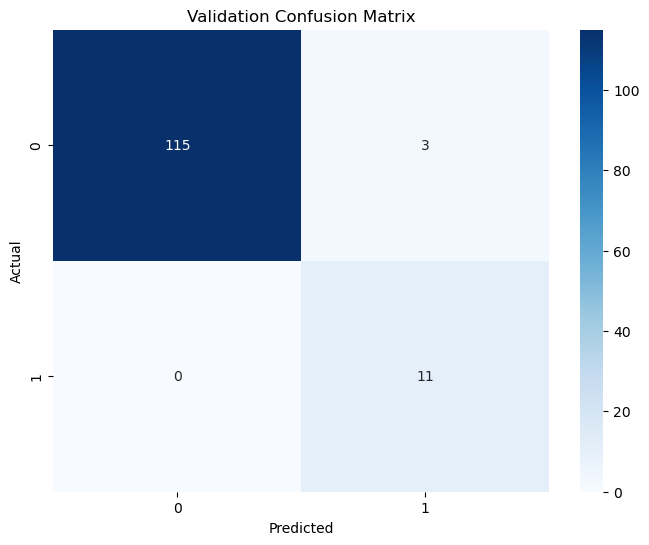

Epoch [17/30]
  Train Loss: 0.2727
  Train Recall: 0.9918
  Validation Recall: 0.7857


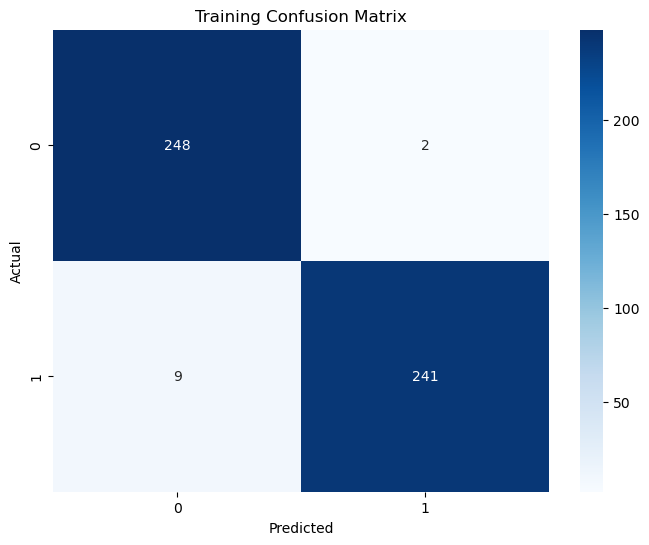

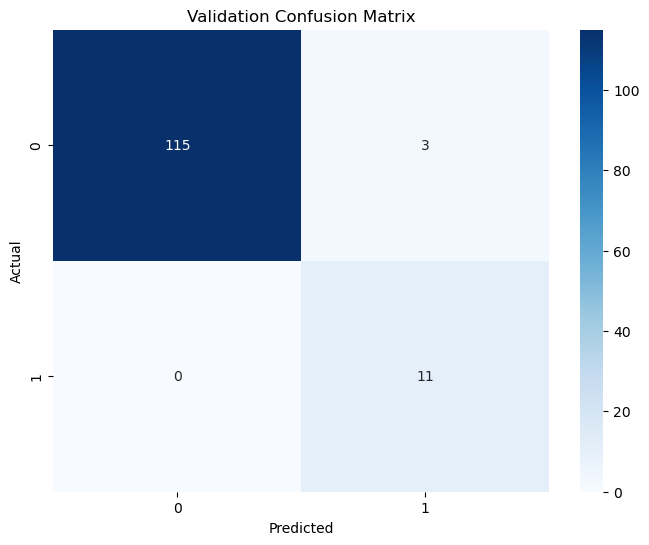

Epoch [18/30]
  Train Loss: 0.4339
  Train Recall: 0.9918
  Validation Recall: 0.7857


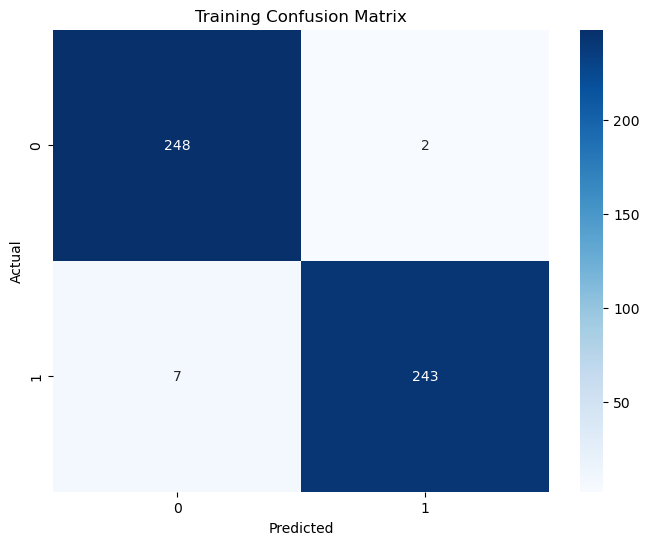

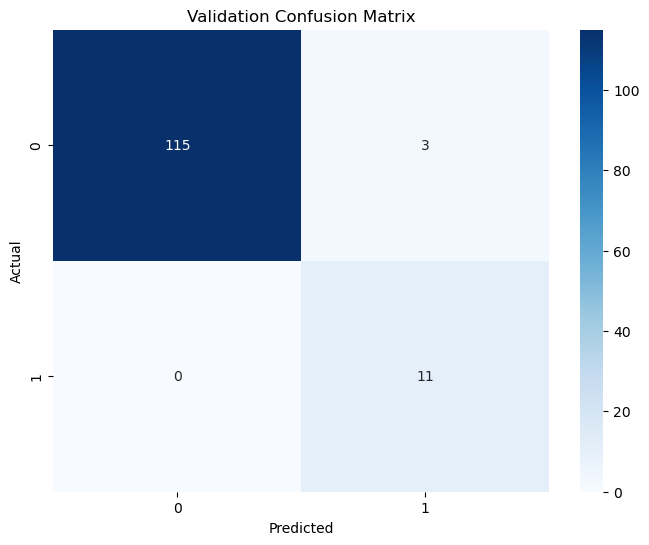

Epoch [19/30]
  Train Loss: 0.3817
  Train Recall: 0.9876
  Validation Recall: 0.8462


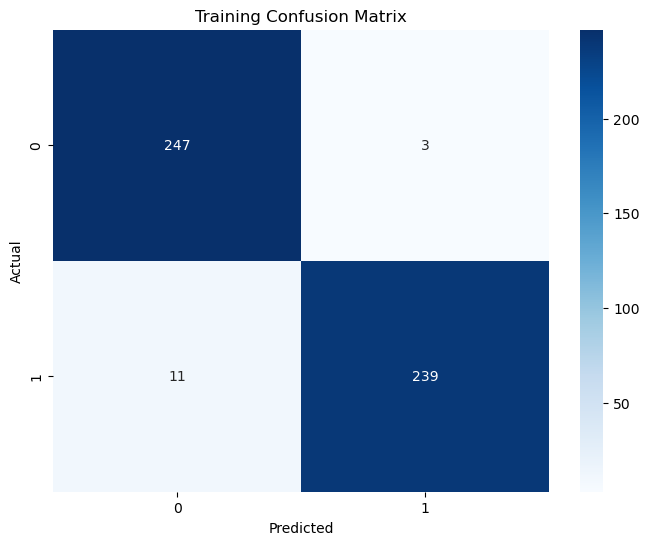

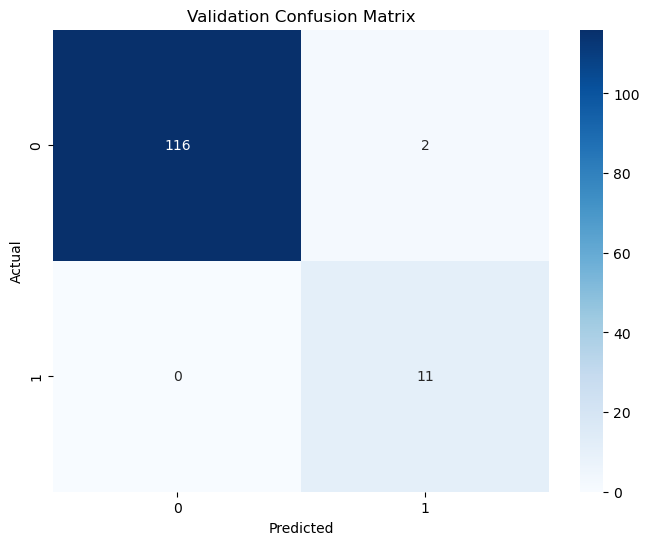

Epoch [20/30]
  Train Loss: 0.4316
  Train Recall: 0.9916
  Validation Recall: 0.8462


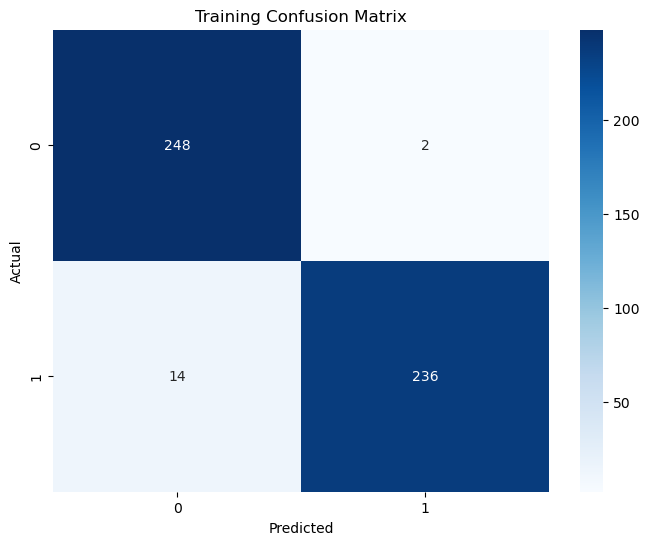

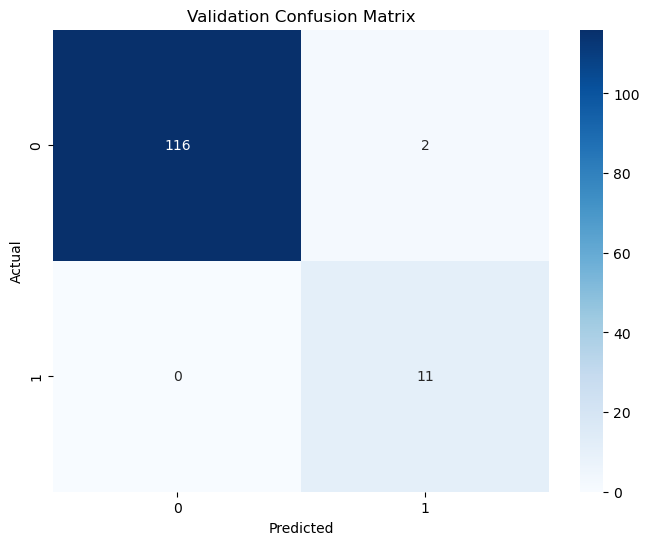

Epoch [21/30]
  Train Loss: 0.0920
  Train Recall: 1.0000
  Validation Recall: 0.8462


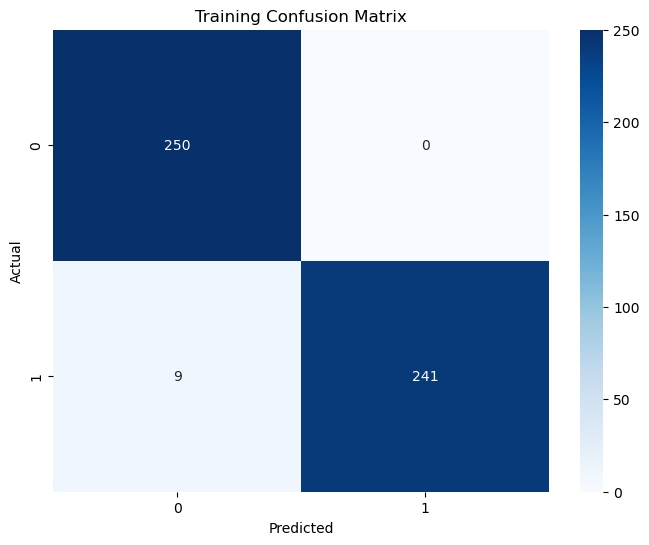

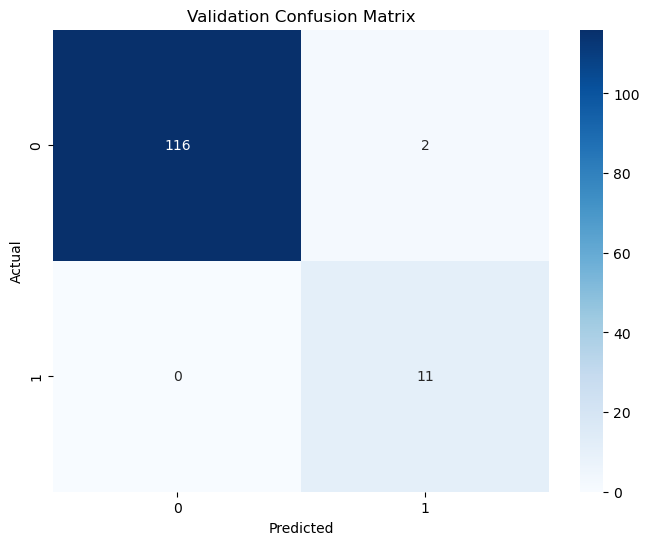

Epoch [22/30]
  Train Loss: 0.1237
  Train Recall: 1.0000
  Validation Recall: 0.8462


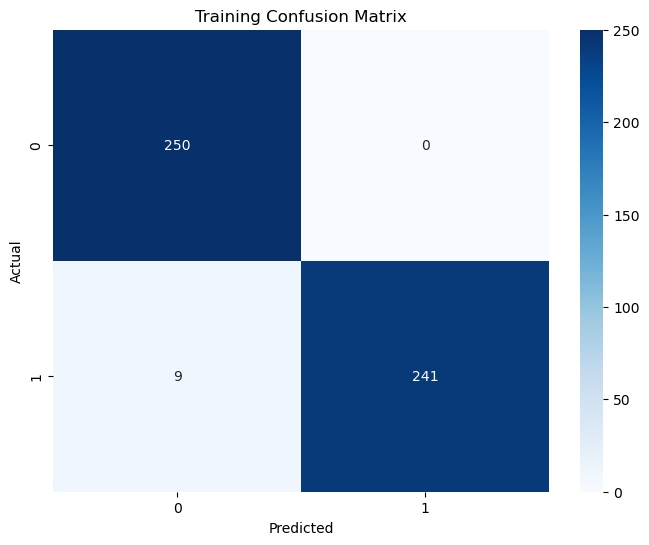

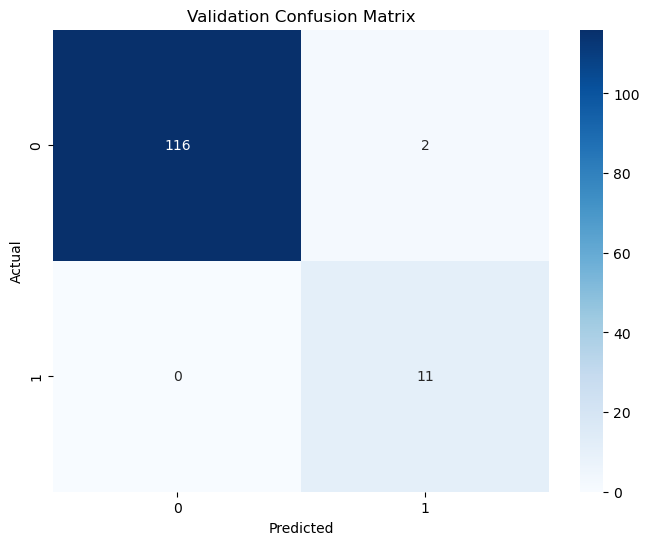

Epoch [23/30]
  Train Loss: 0.0755
  Train Recall: 1.0000
  Validation Recall: 0.8462


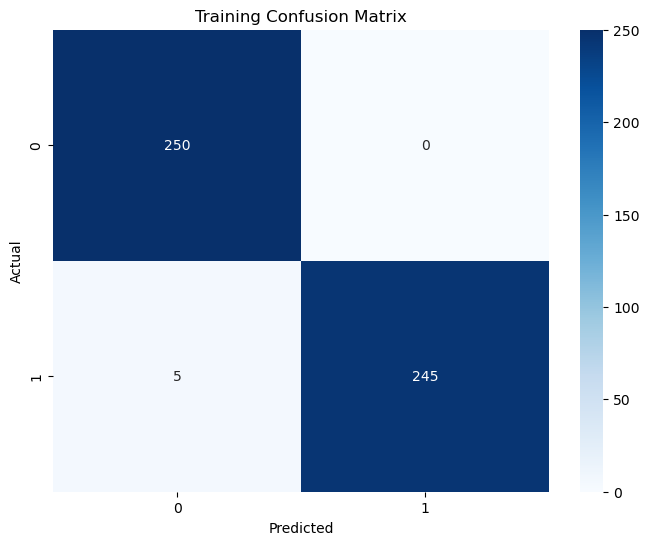

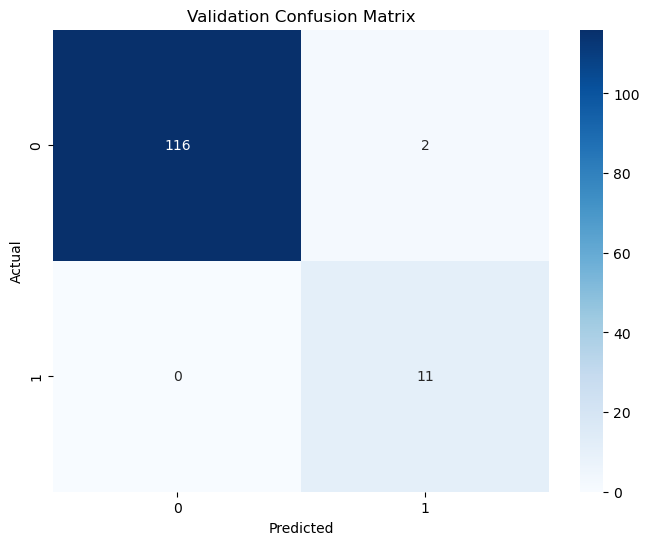

Epoch [24/30]
  Train Loss: 0.1509
  Train Recall: 0.9960
  Validation Recall: 0.8462


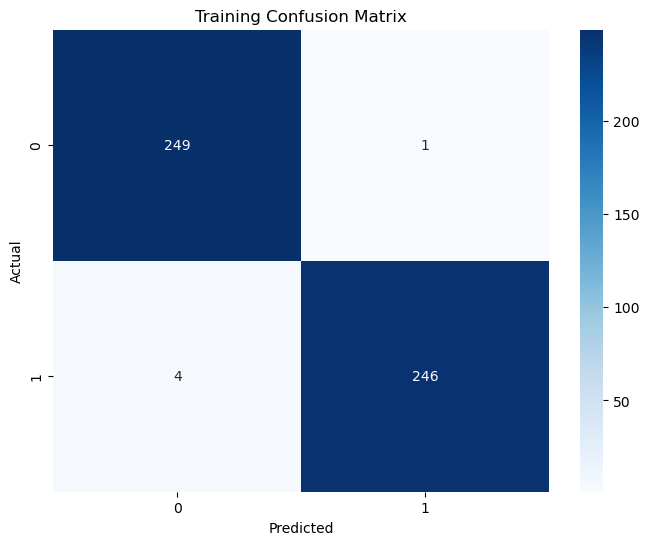

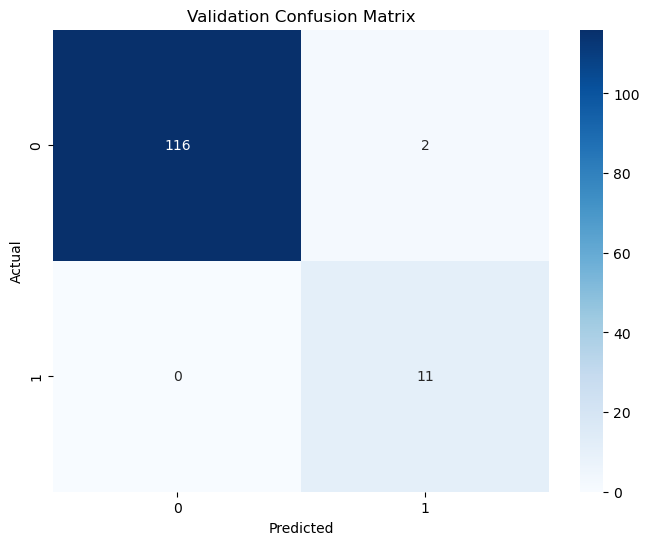

KeyboardInterrupt: 

In [33]:
train_with_precision(sslnet, train_loader, val_favorable_loader, device)

In [36]:
def print_test_results(y_true_,y_hat_):
    print("Test accuracy: ", (y_true_ == y_hat_).mean())
    print("Test F1: ", f1_score(y_true_, y_hat_, average='weighted'))
    print("Class balance in test set: ",np.unique(y_true_, return_counts=True))
    conf_matrix_ = confusion_matrix(y_true_, y_hat_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Validation Confusion Matrix')
    plt.show()

              precision    recall  f1-score   support

    Negative       1.00      0.98      0.99       118
    Positive       0.85      1.00      0.92        11

    accuracy                           0.98       129
   macro avg       0.92      0.99      0.95       129
weighted avg       0.99      0.98      0.99       129



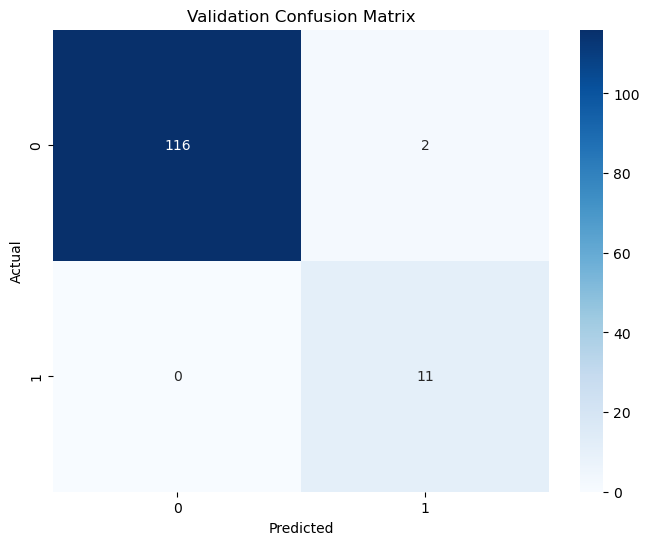

In [48]:
sslnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels, _ in val_favorable_loader:  
        inputs = inputs.to(device).double()  
        outputs = sslnet(inputs)
        _, predicted = torch.max(outputs, 1)
    
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

matrix_c=confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_c, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()